In [ ]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace
from IPython.utils import traitlets as _traitlets

/tmp/ipykernel_2026101/3341169811.py:4: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


<h1><center> Analyzing Learner Output </center></h1>

In this notebook, we will investigate the model predictions and will try to identify any potential biases. In particular, we will be after any pattern that could allow us to improve the model:
+ We will investigate the probability distribution by action type
+ We will investigate the spatial distribution of actions by type

In [ ]:
# hide
import glob
import os
import pickle
import tempfile
import warnings
from pathlib import Path
from random import sample
from typing import List, Tuple

import numpy as np
import pandas as pd
from fastcore.basics import *
from fastcore.foundation import *
from fastcore.xtras import load_pickle, save_pickle
from progressbar import progressbar
from tsai.all import *

from footSeq.datastruct.core import *
from footSeq.model.learner import *
from footSeq.plots import *

# Data preparation

Let's start by loading the model we want to investigate:

In [ ]:
# hide
model_name = "LSTM_FCN_bidir-True_layers-2_no_goal_prop-2"
base_path = Path(".")

learn = load_all(
    path=base_path / "models" / model_name,
    dls_fname="dls",
    model_fname="model",
    learner_fname="learner",
    device="cpu",
    verbose=True,
)

Learner loaded:
path          = 'models/LSTM_FCN_bidir-True_layers-2_no_goal_prop-2'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


Next, we will select a number of files to test the model on. Ideally, these files should not be part of the training/validation set.

In [ ]:
# hide
data_path = Path("/sequences")
used_files = learn.dls.tfms.train_files + learn.dls.tfms.valid_files
all_files = data_path.ls(file_exts=".csv")

test_files = L(set(all_files) - set(used_files))
train_goals, test_goals, no_goals = pick_files(test_files[:500000])

100% (500000 of 500000) |################| Elapsed Time: 0:06:22 Time:  0:06:22


In [ ]:
# hide
no_goal_prop = 2
goals_info = pd.concat([train_goals, test_goals], axis=0)
n_no_goals = int(goals_info.shape[0] * no_goal_prop)

files_info = (
    pd.concat([goals_info, no_goals.sample(n_no_goals)], axis=0)
    .sample(frac=1, ignore_index=True)
    .sort_values(["gameId", "possNumber", "nSteps"])
    .drop_duplicates(["gameId", "possNumber"], keep="last")
)

In [ ]:
# hide
files_info.groupby("target").size()

target
goal       490
no-goal    994
dtype: int64

Finally, we can now run some predictions that can be used in the analysis steps:

In [ ]:
# hide
def _prob(file):
    try:
        _probs = learn.predict_poss(pd.read_csv(file))
    except:
        _probs = None
    return _probs


probs_file_path = Path("./models") / model_name / "sample_probs.csv"
if os.path.isfile(probs_file_path):
    probs = pd.read_csv(probs_file_path)
else:
    n_files = 500 if files_info.shape[0] > 500 else files_info.shape[0]
    probs = pd.concat(
        [_prob(file) for file in files_info.sample(n_files).file]
    ).reset_index(drop=True)
    probs.to_csv(Path("./models") / model_name / "sample_probs.csv")

# Probability distribution by action

The first step in our analysis is to investigate the distribution of probability by action type. It should allow us to identify some obvious issues in our data-preparation or how we present the data to the network:

In [ ]:
# hide
probs.groupby(["generic_action_type_name", "type_name"])[
    "proba_goal"
].describe().sort_values(["generic_action_type_name", "50%"])

count  \
generic_action_type_name type_name                                              
Additional markers       Opening                                         32.0   
Bad ball control         Bad ball control                                10.0   
Ball out of the field    Ball out of the field                           10.0   
Ball receiving           Ball receiving                                 763.0   
Challenges               Air challenges / won                            33.0   
                         Challenge                                       41.0   
                         Unsuccessfull dribbling                          9.0   
                         Tackles successful                              10.0   
                         Successfull dribbling                           36.0   
Clearance                Clearance                                        1.0   
Cross                    Inaccurate set-piece cross                       4.0   
                         Accurate crossing from set piece                 2.0   
                         Inaccurate blocked cross                         2.0   
                         Crosses inaccurate                              15.0   
                         Crosses accurate                                 9.0   
                         Misplaced crossing from set piece with a shot    3.0   
                         Accurate crossing from set piece with a shot     6.0   
                         Set piece cross with shot                        2.0   
Discipline               Foul                                             5.0   
Free ball pick up        Free ball pick up                              137.0   
Goalkeeper's action      Save                                             2.0   
                         Good interception of goalkeeper                  2.0   
                         Bad interception of goalkeeper                   1.0   
Grave mistake            Grave mistake                                    7.0   
                         Unforced mistake                                 3.0   
Interception             Cross interception                               1.0   
                         Pass interceptions                              68.0   
                         Shots blocked                                   10.0   
                         Key interception                                13.0   
                         Mistake while creating the offside trap          3.0   
                         Successful play on offside line                  3.0   
Pass                     Attacking pass inaccurate                      126.0   
                         Non attacking pass accurate                    464.0   
                         Non attacking pass inaccurate                    2.0   
                         Inaccurate extra attacking pass                  2.0   
                         Attacking pass accurate                        801.0   
                         Inaccurate key pass                              3.0   
                         Extra attacking pass accurate                   11.0   
                         Accurate key pass                               23.0   
Possession               Possession                                      93.0   
Shot                     Wide shot                                        3.0   
                         Shot blocked                                     9.0   
                         Shot blocked by field player                     2.0   
                         Shot on target                                  13.0   
Tactical formation       4-4-2 classic                                    1.0   

                                                                            mean  \
generic_action_type_name type_name                                                 
Additional markers       Opening                                        0.744342   
Bad ball con

# Spatial distribution of probability by action

It also useful to visualize the distribution of the probability mass over the pitch for a given action and see if it is line with our intuition:

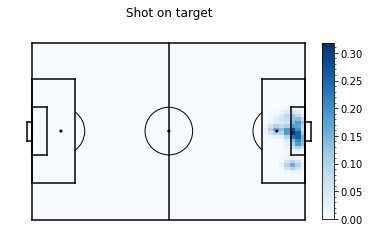

In [ ]:
# hide
action_name = "Shot on target"
hm_tabl = dens_prob(probs[probs.type_name == action_name])
_ = plot_heatmap(
    dens_arr=hm_tabl,
    fieldcolor="white",
    linecolor="black",
    cmap="Blues",
    title=action_name,
)

In [ ]:
## TODO: plot it multiple actions on a pitch

# Predict one game

In [ ]:
from footSeq.config.mongo import mongo_init

mongo_init("prod_atlas")

game_id = 1998205

game_probs = learn.predict_game(game_id, save=False)

100% (156 of 156) |######################| Elapsed Time: 3:54:37 Time:  3:54:37


In [ ]:
game_probs.to_csv("/home/tarak/Downloads/action_values_1998205.csv")